In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from utils.preprocess import preprocess_leaf_image
from utils.feature_extraction import (
    extract_color_features,
    extract_shape_features,
    extract_texture_features,
    extract_edge_features,
    extract_vein_features,
    extract_leaf_features
)


(np.float64(-0.5), np.float64(319.5), np.float64(239.5), np.float64(-0.5))

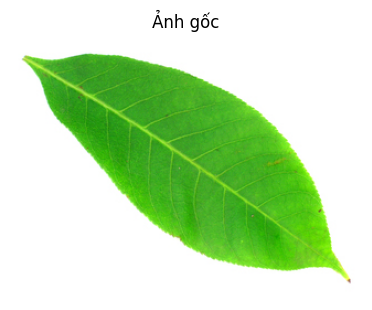

In [2]:
# --- Đường dẫn ảnh mẫu ---
image_path = 'test_images/Leaf-type-in-db/83.jpg'

# Bước 1: Đọc ảnh gốc
original = cv2.imread(image_path)
original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(original_rgb)
plt.title('Ảnh gốc')
plt.axis('off')


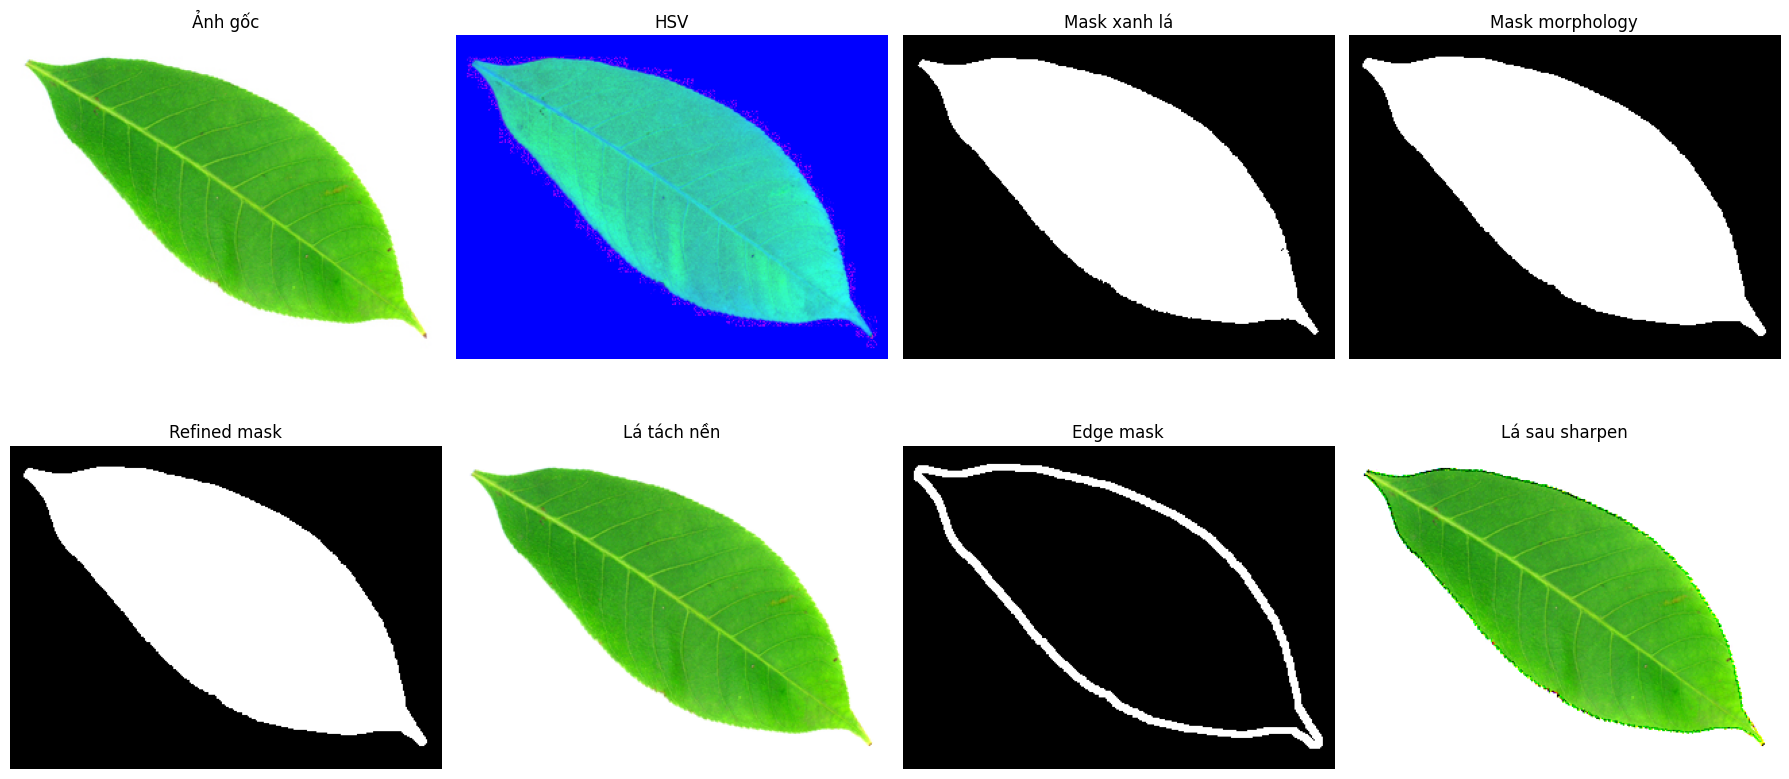

In [3]:
# Bước 2: Tiền xử lý - giống như trong preprocess_leaf_image
hsv = cv2.cvtColor(original_rgb, cv2.COLOR_RGB2HSV)

lower_green1 = np.array([30, 50, 50])
upper_green1 = np.array([90, 255, 255])
lower_green2 = np.array([30, 30, 30])
upper_green2 = np.array([90, 150, 150])
mask1 = cv2.inRange(hsv, lower_green1, upper_green1)
mask2 = cv2.inRange(hsv, lower_green2, upper_green2)
combined_mask = cv2.bitwise_or(mask1, mask2)

kernel_close = np.ones((5,5), np.uint8)
kernel_dilate = np.ones((3,3), np.uint8)
mask_clean = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel_close)
mask_clean = cv2.dilate(mask_clean, kernel_dilate, iterations=1)

contours, _ = cv2.findContours(mask_clean.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
refined_mask = np.zeros_like(mask_clean)
if contours:
    largest = max(contours, key=cv2.contourArea)
    cv2.drawContours(refined_mask, [largest], -1, 255, thickness=-1)

M = cv2.moments(largest)
if M["m00"] != 0:
    cx = int(M["m10"] / M["m00"])
    cy = int(M["m01"] / M["m00"])
    h, w = refined_mask.shape
    flood_fill_mask = np.zeros((h+2, w+2), np.uint8)
    cv2.floodFill(refined_mask, flood_fill_mask, (cx, cy), 255)

white_bg = np.ones_like(original_rgb, dtype=np.uint8) * 255
isolated_leaf = np.where(refined_mask[..., None] == 255, original_rgb, white_bg)

edge_mask = np.zeros_like(refined_mask)
cv2.drawContours(edge_mask, [largest], -1, 255, 1)
edge_mask = cv2.dilate(edge_mask, np.ones((3,3), np.uint8), iterations=2)

sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
sharpened = cv2.filter2D(isolated_leaf, -1, sharpen_kernel)
final_image = np.where(edge_mask[..., None] > 0, sharpened, isolated_leaf)

# Bước 3: Hiển thị toàn bộ quá trình tiền xử lý
fig, axes = plt.subplots(2, 4, figsize=(18, 9))
axes = axes.ravel()

axes[0].imshow(original_rgb)
axes[0].set_title("Ảnh gốc")
axes[1].imshow(hsv)
axes[1].set_title("HSV")
axes[2].imshow(combined_mask, cmap='gray')
axes[2].set_title("Mask xanh lá")
axes[3].imshow(mask_clean, cmap='gray')
axes[3].set_title("Mask morphology")
axes[4].imshow(refined_mask, cmap='gray')
axes[4].set_title("Refined mask")
axes[5].imshow(isolated_leaf)
axes[5].set_title("Lá tách nền")
axes[6].imshow(edge_mask, cmap='gray')
axes[6].set_title("Edge mask")
axes[7].imshow(final_image)
axes[7].set_title("Lá sau sharpen")
for ax in axes: ax.axis('off')
plt.tight_layout()
plt.show()

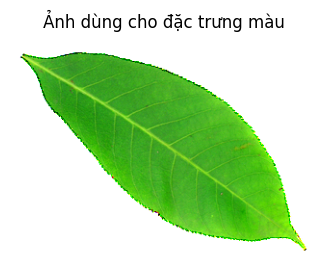

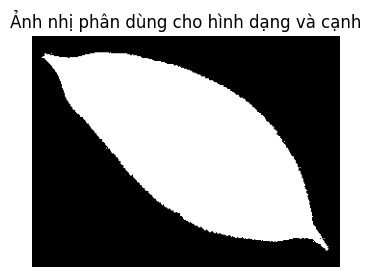

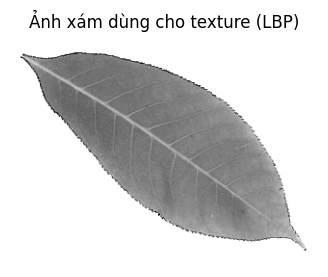

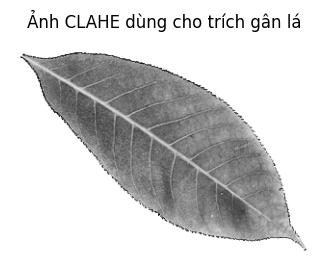


>>> Tổng quan đặc trưng ảnh
- Số chiều đặc trưng tổng hợp: 56
- Đặc trưng màu (HSV): [5.91927083e-01 1.37760417e-02 3.92291667e-01 5.07812500e-04
 3.90625000e-04 3.90625000e-05 1.01562500e-03 5.20833333e-05] ...
- Hu moments: [ -8.33807947 -16.35186354 -18.61571415 -17.97809331 -36.24918948
 -26.05016919 -35.79971734]
- Texture (LBP hist): [0.08819566 0.03116907 0.03095767 0.01614608 0.03821151 0.0294514
 0.01623857 0.02765446 0.03241108 0.68956451]
- Vein: [0.21911154 0.43421036 1.0573076  0.49755481]
- Đặc trưng cạnh: [ 77.46796885   2.29474635 353.23092963]


In [4]:
# Bước 4: Trích xuất đặc trưng và hiển thị các bước hình ảnh
# --- Color ---
plt.figure(figsize=(6,3))
plt.imshow(final_image)
plt.title("Ảnh dùng cho đặc trưng màu")
plt.axis('off')
plt.show()
color_feat = extract_color_features(final_image)

# --- Shape & Edge ---
gray_shape = cv2.cvtColor(final_image, cv2.COLOR_RGB2GRAY)
binary_shape = (gray_shape < 250).astype(np.uint8)
plt.figure(figsize=(6,3))
plt.imshow(binary_shape, cmap='gray')
plt.title("Ảnh nhị phân dùng cho hình dạng và cạnh")
plt.axis('off')
plt.show()
edge_feat = extract_edge_features(final_image)
shape_feat = extract_shape_features(final_image)


# --- Texture---
gray_texture = cv2.cvtColor(final_image, cv2.COLOR_RGB2GRAY)
plt.figure(figsize=(6,3))
plt.imshow(gray_texture, cmap='gray')
plt.title("Ảnh xám dùng cho texture (LBP)")
plt.axis('off')
plt.show()
texture_feat = extract_texture_features(final_image)

# --- Vein ---
gray_vein = cv2.cvtColor(final_image, cv2.COLOR_RGB2GRAY)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
enhanced = clahe.apply(gray_vein)
plt.figure(figsize=(6,3))
plt.imshow(enhanced, cmap='gray')
plt.title("Ảnh CLAHE dùng cho trích gân lá")
plt.axis('off')
plt.show()
vein_feat = extract_vein_features(final_image)

# Tổng hợp
full_feature = extract_leaf_features(final_image)

print("\n>>> Tổng quan đặc trưng ảnh")
print(f"- Số chiều đặc trưng tổng hợp: {len(full_feature)}")
print(f"- Đặc trưng màu (HSV): {color_feat[:8]} ...")
print(f"- Hu moments: {shape_feat[:7]}")
print(f"- Texture (LBP hist): {texture_feat}")
print(f"- Vein: {vein_feat}")
print(f"- Đặc trưng cạnh: {edge_feat}")